In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
# 多行输出
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" 

# NLP 文档分类 IMDB

In [2]:
from fastai.text import *

## 数据准备

In [3]:
root = untar_data(URLs.IMDB_SAMPLE)
root
root.ls()

PosixPath('/home/lyc/.fastai/data/imdb_sample')

[PosixPath('/home/lyc/.fastai/data/imdb_sample/data_save.pkl'),
 PosixPath('/home/lyc/.fastai/data/imdb_sample/texts.csv')]

- 查看数据
- 标签指示文本是正面评价还是反面评价
- is_valid 表示是否是验证集

In [4]:
df = pd.read_csv(root/'texts.csv')
df.head()
df.tail()

,label,text,is_valid
0,negative,Un-bleeping-believable! Meg Ryan doesn't even ...,False
1,positive,This is a extremely well-made film. The acting...,False
2,negative,Every once in a long while a movie will come a...,False
3,positive,Name just says it all. I watched this movie wi...,False
4,negative,This movie succeeds at being one of the most u...,False


,label,text,is_valid
995,negative,There are many different versions of this one ...,True
996,positive,Once upon a time Hollywood produced live-actio...,True
997,negative,Wenders was great with Million $ Hotel.I don't...,True
998,negative,Although a film with Bruce Willis is always wo...,True
999,positive,"A compelling, honest, daring, and unforgettabl...",True


In [5]:
df.text[0]  # negative

"Un-bleeping-believable! Meg Ryan doesn't even look her usual pert lovable self in this, which normally makes me forgive her shallow ticky acting schtick. Hard to believe she was the producer on this dog. Plus Kevin Kline: what kind of suicide trip has his career been on? Whoosh... Banzai!!! Finally this was directed by the guy who did Big Chill? Must be a replay of Jonestown - hollywood style. Wooofff!"

## 创建数据束

In [6]:
# data = TextDataBunch.from_csv(root, 'texts.csv', text_cols=1, label_cols=0)

In [7]:
# data.train_ds[0]

1. 图像数据和文本数据都是 **非结构化数据**
2. 图像数据本身就是整型或者浮点型，可以直接使用，但是文本数据不可以直接使用，必须要先转化为数字形式
3. tokenization and numericalization（TextDataBunch） 分词-数值化

- 为论文避免再次计算，我们可以保存预处理后的数据束

In [8]:
# data.save()  # 保存数据

- 重新加载数据束

In [9]:
data = load_data(root)

### Tokenization

- 这个步骤即：把文本分割成单词即 token，最简单的方式是按照空格进行分割（英文）
    - 需要注意标点
    - 特殊的符号处理
    - 词的处理，如 isn't

In [10]:
doc(TextClasDataBunch)

class TextClasDataBunch [source] [test] TextClasDataBunch ( train_dl : DataLoader , valid_dl : DataLoader , fix_dl : DataLoader = None , test_dl : Optional [ DataLoader ]= None , device : device = None , dl_tfms : Optional [ Collection [ Callable ]]= None , path : PathOrStr = '.' , collate_fn : Callable = 'data_collate' , no_check : bool = False ) :: TextDataBunch 
 
 × No tests found for TextClasDataBunch . To contribute a test please refer to this guide and this discussion . Create a TextDataBunch suitable for training an RNN classifier. 
 Show in docs

In [11]:
data = TextClasDataBunch.from_csv(root, 'texts.csv')
data.show_batch()

text,target
"xxbos xxmaj raising xxmaj victor xxmaj vargas : a xxmaj review \n \n xxmaj you know , xxmaj raising xxmaj victor xxmaj vargas is like sticking your hands into a big , steaming bowl of xxunk . xxmaj it 's warm and gooey , but you 're not sure if it feels right . xxmaj try as i might , no matter how warm and gooey xxmaj raising xxmaj",negative
"xxbos xxup the xxup shop xxup around xxup the xxup corner is one of the sweetest and most feel - good romantic comedies ever made . xxmaj there 's just no getting around that , and it 's hard to actually put one 's feeling for this film into words . xxmaj it 's not one of those films that tries too hard , nor does it come up with",positive
"xxbos xxmaj now that xxmaj che(2008 ) has finished its relatively short xxmaj australian cinema run ( extremely limited xxunk screen in xxmaj sydney , after xxunk ) , i can xxunk join both xxunk of "" xxmaj at xxmaj the xxmaj movies "" in taking xxmaj steven xxmaj soderbergh to task . \n \n xxmaj it 's usually satisfying to watch a film director change his style /",negative
"xxbos xxmaj many neglect that this is n't just a classic due to the fact that it 's the first xxup 3d game , or even the first xxunk - up . xxmaj it 's also one of the first xxunk games , one of the xxunk definitely the first ) truly claustrophobic games , and just a pretty well - rounded gaming experience in general . xxmaj with graphics",positive
"xxbos i really wanted to love this show . i truly , honestly did . \n \n xxmaj for the first time , gay viewers get their own version of the "" xxmaj the xxmaj bachelor "" . xxmaj with the help of his obligatory "" hag "" xxmaj xxunk , xxmaj james , a good looking , well - to - do thirty - something has the chance",negative


- ‘s 是一个词 it’s
- didn't 被分为 did n't
- HTML 符号被删除
- xx 开头的表示不确定的词
- 所有的词都 小写

### Numericalization

- 一旦我们从文本中提取了标记，我们就会通过创建所有单词的列表来转换为整数。
- 我们**只保留至少出现两次且最大词汇量为60,000（默认情况下）**
- 替换未知词 `UNK`

- ids 和 tokens 的对应关系被存放在 data.vocab.itos ,(int 2 string)

In [12]:
data.vocab.itos[5:15]

['xxmaj', 'xxup', 'xxrep', 'xxwrep', 'the', ',', '.', 'and', 'a', 'of']

In [13]:
x, y = data.train_ds[0]
y

Category negative

In [14]:
x

Text xxbos i rented this film to see what might be a bloody , non stop action movie and got this overly sentimental and super cheap low budget action - drama that makes xxmaj xxunk look like xxmaj die xxmaj hard . xxmaj lou and xxmaj reb are in xxmaj vietnam and as xxmaj lou saves xxmaj reb from the xxunk , he gets shot in the head in what is easily one of the worst effects ever . xxmaj the xxmaj vietnam scenes are shot in xxunk xxunk , i swear ! xxmaj lou is now brain damaged and xxmaj reb and him live together and own a bar . xxmaj super xxunk . xxmaj lou is convinced to fight in a cage for money and xxmaj reb goes on a killing spree to get him back . xxmaj there is no good fight scenes at all , the punches are two xxunk away from a person . xxmaj characters personalities change in matter of seconds . xxmaj one guy is a bad and in the next scene he 's good . xxmaj the acting is horrid and the music is some overly sentimental xxmaj frank xxmaj stallone sounding song that would make yo

In [15]:
# 语言模型通常会占用比较多的内存资源
data = (TextList.from_csv(root, 'texts.csv', cols='text')
                .split_from_df(col=2)
                .label_from_df(cols=0)
                .databunch(bs=32))

In [16]:
data.show_batch()

text,target
"xxbos xxmaj raising xxmaj victor xxmaj vargas : a xxmaj review \n \n xxmaj you know , xxmaj raising xxmaj victor xxmaj vargas is like sticking your hands into a big , xxunk bowl of xxunk . xxmaj it 's warm and gooey , but you 're not sure if it feels right . xxmaj try as i might , no matter how warm and gooey xxmaj raising xxmaj",negative
"xxbos xxup the xxup shop xxup around xxup the xxup corner is one of the xxunk and most feel - good romantic comedies ever made . xxmaj there 's just no getting around that , and it 's hard to actually put one 's feeling for this film into words . xxmaj it 's not one of those films that tries too hard , nor does it come up with",positive
"xxbos xxmaj now that xxmaj che(2008 ) has finished its relatively short xxmaj australian cinema run ( extremely limited xxunk screen in xxmaj xxunk , after xxunk ) , i can xxunk join both xxunk of "" xxmaj at xxmaj the xxmaj movies "" in taking xxmaj steven xxmaj soderbergh to task . \n \n xxmaj it 's usually satisfying to watch a film director change his style /",negative
"xxbos xxmaj this film sat on my xxmaj xxunk for weeks before i watched it . i xxunk a self - indulgent xxunk flick about relationships gone bad . i was wrong ; this was an xxunk xxunk into the screwed - up xxunk of xxmaj new xxmaj xxunk . \n \n xxmaj the format is the same as xxmaj max xxmaj xxunk ' "" xxmaj la xxmaj xxunk",positive
"xxbos xxmaj many neglect that this is n't just a classic due to the fact that it 's the first xxup 3d game , or even the first xxunk - up . xxmaj it 's also one of the first xxunk games , one of the xxunk definitely the first ) truly claustrophobic games , and just a pretty well - xxunk gaming experience in general . xxmaj with graphics",positive


## 构建模型

- 使用完整的数据集

In [17]:
root = untar_data(URLs.IMDB)
root.ls()

[PosixPath('/home/lyc/.fastai/data/imdb/data_lm.pkl'),
 PosixPath('/home/lyc/.fastai/data/imdb/train'),
 PosixPath('/home/lyc/.fastai/data/imdb/test'),
 PosixPath('/home/lyc/.fastai/data/imdb/README'),
 PosixPath('/home/lyc/.fastai/data/imdb/tmp_clas'),
 PosixPath('/home/lyc/.fastai/data/imdb/tmp_lm'),
 PosixPath('/home/lyc/.fastai/data/imdb/unsup'),
 PosixPath('/home/lyc/.fastai/data/imdb/models'),
 PosixPath('/home/lyc/.fastai/data/imdb/imdb.vocab')]

- unsup 表示没有标注的数据
- 使用预训练模型[wikitext-103](https://einstein.ai/research/blog/the-wikitext-long-term-dependency-language-modeling-dataset)，这个预训练是用来预测下一个词是什么,所以对于 imdb 数据集我们作同样的操作
- 只在训练集作 打乱操作，验证集不做打乱

In [29]:
bs = 32

- filter_by_folder 使用 from_folder 会导致该路径下的所有文件夹被包含进来，但是也有可能这个路径下包含别的文件夹，所以使用 filter_by_folder 进行制定文件夹

In [30]:
data_lm = (TextList.from_folder(root)
            .filter_by_folder(include=['train', 'test', 'unsup']) 
            .split_by_rand_pct(0.1)
            .label_for_lm()           
            .databunch(bs=bs))

KeyboardInterrupt: 

In [ ]:
data_lm.save('data_lm.pkl')

In [21]:
data_lm = load_data(root, 'data_lm.pkl', bs=bs)

In [22]:
data_lm.show_batch()

idx,text
0,"for its story . xxbos xxmaj also known as "" xxmaj stairway to xxmaj heaven "" in the xxup us . xxmaj during xxup wwii xxmaj british xxmaj peter xxmaj carter 's ( xxmaj david xxmaj niven ) plane is shot down in combat but he survives . xxmaj he meets and falls in love with lovely xxmaj june ( xxmaj kim xxmaj hunter ) . xxmaj but it seems"
1,""" xxmaj dragnet "" . \n \n xxrep 7 * xxmaj the xxmaj little xxmaj american ( 7 / 12 / 17 ) xxmaj cecil xxup b. demille ~ xxmaj mary xxmaj pickford , xxmaj jack xxmaj holt , xxmaj raymond xxmaj hatton xxbos i was a little xxunk if i should watch this when it was first shown on xxup cbs . i was one of the many"
2,"xxmaj the photography , cinematography ... all the technical aspects of this remarkable film are first rate . \n \n xxmaj the moral questions raised , from murdering the sexual xxunk to the aftermath of dealing with killing a human being , remain as profound today as they did when this groundbreaking film was released . xxmaj and the classic sequences of attempting to survive in the wilderness after"
3,"xxmaj in any case , the talking heads talk , the main character achieves harmony and enlightenment by painting hearts all over her body with a magic marker , and proceeds to walk around with an even stupider look in her glazed over eyes than she started with . \n \n i want 2 hours of my life back . \n \n xxmaj here 's a couple of"
4,"are bad they are funny , then there are those where you scream "" i want that one and a half hours of my life xxunk ... thats pretty much what this is . \n \n dean cain tries to be an actor but fails . the sfx are really bad ( repeated scenes and rocks that look like falling paper ) and the fake plastic guns that have"


## 模型

In [23]:
arch = AWD_LSTM

In [24]:
learn = language_model_learner(data_lm, arch, drop_mult=0.3)

- 学习率

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


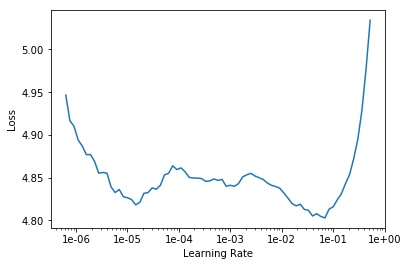

In [25]:
learn.lr_find()
learn.recorder.plot(skip_end=15)

- 训练模型

In [26]:
lr1 = 1e-2

In [28]:
learn.fit_one_cycle(5, lr1, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time


KeyboardInterrupt: 

In [33]:
learn.save('stage1')

SyntaxError: EOL while scanning string literal (<ipython-input-33-7754dd00f70c>, line 1)

In [ ]:
learn.load('stage1')

In [ ]:
learn.recorder.plot_losses()

- stage 2

In [ ]:
learn.unfreeze()

In [ ]:
learn.lr_find()
learn.recorder.plot(skip_end=15)

In [ ]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

In [ ]:
learn.save('stage2')

In [ ]:
learn.load('stage2')

In [ ]:
learn.recorder.plot_losses()

- 预测

In [ ]:
TEXT = "I liked this movie because"
N_WORDS = 40
N_SENTENCES = 2

In [ ]:
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

- 保存编码器

In [ ]:
learn.save_encoder('fine_tuned_enc')

但是，我们的任务是分类而不是预测下一个单词是什么

## 分类

- 我们再次创建一个数据集，只包含有标签的那部分数据

In [ ]:
bs = 32
path = untar_data(URLs.IMDB)

In [ ]:
data_clas = (TextList.from_folder(path, vocab=data_lm.vocab)
             .split_by_folder(valid='test')
             .label_from_folder(classes=['neg', 'pos'])
             .databunch(bs=bs))

data_clas.save('data_clas.pkl')

In [ ]:
data_clas = load_data(path, 'data_clas.pkl', bs=bs)

In [ ]:
data_clas.show_batch()

- 我们使用之前训练好的 **编码器** 进行分类

In [ ]:
arch = AWD_LSTM
learn = text_classifier_learner(data_clas, arch, drop_mult=0.5)
learn.load_encoder('fine_tuned_enc')

- 学习率调整

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(1, 2e-2, moms=(0.8,0.7))

In [ ]:
learn.save('first')

In [ ]:
learn.load('first');

In [ ]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

In [ ]:
learn.save('second')

In [ ]:
learn.load('second')

In [ ]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

In [ ]:
learn.save('third')

In [ ]:
learn.load('third')

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

In [ ]:
learn.predict("I really loved that movie, it was awesome!")

In [ ]:
data.class